# Сегментация клиентской базы сети фитнес-центров

## Общее описание проекта
Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Одна из проблем фитнес-клубов — отток клиентов. Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас. 

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 

**Аналитическая задача** — провести анализ и подготовить план действий по удержанию клиентов. 


    
## Описание данных
Заказчик предоставил клиентскую базу, содержащую данные на месяц до оттока и факт оттока на определённый месяц. Каждая запись характеризуется следующим единым набором признаков, описывающих клиента:

**за месяц до проверки факта оттока**

|**Признак**|**Описание признака**|
|---:|:---|
|`gender`|пол|
|`Near_Location`|проживание или работа в районе, где находится фитнес-центр|
|`Partner`|сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)|
|`Promo_friends`|факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)|
|`Phone`|наличие контактного телефона|
|`Age`|возраст|
|`Lifetime`|время с момента первого обращения в фитнес-центр (в месяцах)|

**за месяц, в котором проводилась проверка факта оттока**

|**Признак**|**Описание признака**|
|---:|:---|
|`Contract_period`|длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)|
|`Month_to_end_contract`|срок до окончания текущего действующего абонемента (в месяцах)|
|`Group_visits`|факт посещения групповых занятий|
|`Avg_class_frequency_total`|средняя частота посещений в неделю за все время с начала действия абонемента|
|`Avg_class_frequency_current_month`|средняя частота посещений в неделю за предыдущий месяц|
|`Avg_additional_charges_total`|суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон|
|`Churn`|факт оттока в текущем месяце|



In [1]:
# Ваш код здесь
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

%matplotlib inline

In [2]:
#import matplotlib.pyplot as plt
#import seaborn as sns
# стандартизируют набор данных
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.neighbors import KNeighborsClassifier

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [6]:
import scipy

In [7]:
import pandas_profiling

In [8]:
# opened file
df=pd.read_csv('project5.csv')

In [9]:
df=pd.read_csv('project5.csv')
df.head(4)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0


In [10]:
df.tail(2)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0
3999,1,0,1,0,0,12,1,30,178.861814,12.0,1,1.101832,1.035270,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [12]:
# приведем название колонок к удобному типу
df.columns=df.columns.str.lower()
df.columns=['gend','location','partner','p_friends','phone','con_period','g_visits','age','avg_total','end_contract','lifetime','frequency_current_month','frequency_week','churn']

In [13]:
dict_to_rus={'gend':'пол',
             'location':'проживание у фитнес центра',
             'partner':'сотрудник компании-партнёра клуба',
             'p_friends':'промо-друг',
             'phone':'телефон',
             'con_period':'длительность текущего абонемента',
             'g_visits':'факт посещения групповых занятий',
             'age':'возраст',
             'avg_total':"суммарная выручка  фитнес-центра",
             'end_contract':'срок до окончания текущего абонемента',
             'lifetime':'первое обращения в фитнес-центр',
             'frequency_current_month':'средняя частота посещений в неделю за пред.мес.',
             'frequency_week':'средняя частота посещений в неделю за все время',
             'churn':'факт оттока в текущем месяце'
            }

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gend                     4000 non-null   int64  
 1   location                 4000 non-null   int64  
 2   partner                  4000 non-null   int64  
 3   p_friends                4000 non-null   int64  
 4   phone                    4000 non-null   int64  
 5   con_period               4000 non-null   int64  
 6   g_visits                 4000 non-null   int64  
 7   age                      4000 non-null   int64  
 8   avg_total                4000 non-null   float64
 9   end_contract             4000 non-null   float64
 10  lifetime                 4000 non-null   int64  
 11  frequency_current_month  4000 non-null   float64
 12  frequency_week           4000 non-null   float64
 13  churn                    4000 non-null   int64  
dtypes: float64(4), int64(10)

In [15]:
df['frequency_current_month'].unique()

array([0.02039795, 1.92293606, 1.85909835, ..., 2.78614636, 1.63010814,
       1.10183221])

In [16]:
# анализ на уникальные занчения показал что никаких аномалий нет

In [17]:
#проверка на дубликаты
df.duplicated().sum()

0

In [18]:
#проверка на нулевые значения
df.isnull().sum()

gend                       0
location                   0
partner                    0
p_friends                  0
phone                      0
con_period                 0
g_visits                   0
age                        0
avg_total                  0
end_contract               0
lifetime                   0
frequency_current_month    0
frequency_week             0
churn                      0
dtype: int64

Промежуточный вывод: Видим, что в целом установленные типы признаков соответствуют их смысловой нагрузке. Однако, заметим следующее. Имеется достаточно несколько бинарных признаков и если бы далее не планировалось использовать методы машинного обучения, то, скорее всего, типы соответствующих признаков были бы изменены на bool. Здесь же преобразования типов данных проводить не будем.

Заметим, что в выборке пропусков и дубликатов нет.

В датасете  нулевых значений и дубликатов нет

gend                                              location            \
        count      mean       std  min  25%  50%  75%  max    count      mean   
churn                                                                           
0      2939.0  0.510037  0.499984  0.0  0.0  1.0  1.0  1.0   2939.0  0.873086   
1      1061.0  0.510839  0.500118  0.0  0.0  1.0  1.0  1.0   1061.0  0.768143   

       ... frequency_current_month           frequency_week            \
       ...                     75%       max          count      mean   
churn  ...                                                              
0      ...                2.732944  6.023668         2939.0  2.027882   
1      ...                1.956438  3.478646         1061.0  1.044546   

                                                              
            std  min       25%       50%       75%       max  
churn                                                         
0      1.018994  0.0  1.297021  2.046697  2.740648  6.146783  
1      0.770237  0.0  0.421337  0.979445  1.588576  3.540271  

[2 rows x 104 columns]

### Описательная статистика

In [7]:
df.groupby('churn').describe()

gend                                              location            \
        count      mean       std  min  25%  50%  75%  max    count      mean   
churn                                                                           
0      2939.0  0.510037  0.499984  0.0  0.0  1.0  1.0  1.0   2939.0  0.873086   
1      1061.0  0.510839  0.500118  0.0  0.0  1.0  1.0  1.0   1061.0  0.768143   

       ... frequency_current_month           frequency_week            \
       ...                     75%       max          count      mean   
churn  ...                                                              
0      ...                2.732944  6.023668         2939.0  2.027882   
1      ...                1.956438  3.478646         1061.0  1.044546   

                                                              
            std  min       25%       50%       75%       max  
churn                                                         
0      1.018994  0.0  1.297021  2.046697  2.740648  6.146783  
1      0.770237  0.0  0.421337  0.979445  1.588576  3.540271  

[2 rows x 104 columns]

In [62]:
# разделение dataframe на 2 группы
df0=df[df['churn']==0] # остался
df1=df[df['churn']==1]# ушел

In [63]:
df1.head()

,gend,location,partner,p_friends,phone,con_period,g_visits,age,avg_total,end_contract,lifetime,frequency_current_month,frequency_week,churn
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
11,1,1,1,0,1,1,0,27,266.783824,1.0,2,2.348535,1.584316,1
13,1,1,0,0,1,1,1,27,152.748668,1.0,1,0.000000,0.000000,1
21,0,0,0,0,1,1,0,30,153.198594,1.0,3,0.636382,0.000000,1
23,1,1,0,0,1,1,1,32,276.079882,1.0,1,1.420637,1.043101,1


In [64]:
#анализ средних значение группы ушедших
df0_1=df0[['age','avg_total','end_contract','lifetime','frequency_current_month','frequency_week']]
df0_1.describe()

,age,avg_total,end_contract,lifetime,frequency_current_month,frequency_week
count,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000
mean,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
std,3.009933,99.801599,4.363522,3.874780,1.016006,1.018994
min,19.000000,0.171862,1.000000,0.000000,0.000000,0.000000
25%,28.000000,76.920993,1.000000,2.000000,1.283137,1.297021
50%,30.000000,149.881171,6.000000,4.000000,2.043252,2.046697
75%,32.000000,224.448274,10.000000,6.000000,2.732944,2.740648
max,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783


In [65]:
#анализ средних значение группы ушедших
df1_1=df1[['age','avg_total','end_contract','lifetime','frequency_current_month','frequency_week']]
df1_1=df1_1.describe()
df1_1

,age,avg_total,end_contract,lifetime,frequency_current_month,frequency_week
count,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000
mean,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546
std,2.895163,77.696419,1.964593,1.110799,0.694705,0.770237
min,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,25.000000,50.629127,1.000000,0.000000,1.010771,0.421337
50%,27.000000,103.814686,1.000000,1.000000,1.491187,0.979445
75%,29.000000,165.616858,1.000000,1.000000,1.956438,1.588576
max,38.000000,425.535220,12.000000,9.000000,3.478646,3.540271


Промежуточный выход: Анализ значений описательных статистик позволяет сделать следующие выводы:

### для описательной статистики были выбраны не категориальные признаки:
1. age-аномальных значений нет.Среднее по группам имеют небольшие различия.
2. avg_total-аномальных значений для этого признака нет. Среднее по группам различаются. При чем прцентали для 50% имеют существенные различия для групп
3. end_contract-анаомалий нет. Имеются существенные различия для среднего и для мах значений по группам.Этот признаки необходимо отнести в категориальные
4. lifetime -аномальных значений для этого признака нет.Имеются  различия для среднего и для мах значений по группам. Этот признаки необходимо отнести в категориальные
5. frequency_current_month-аномальных значений для этого признака нет.Имеются существенные различия для среднего и для мах значений по группам.
6. frequency_week-аномальных значений для этого признака нет.Имеются существенные различия для среднего и для мах значений по группам.
Признаки frequency_current_month и frequency_week имеют небольшие различия в цифрах по описательной статистики
все выбранные признаки необходимо раасмотреть более детально.

## Анализ аномальных значений

In [ ]:
проведем анализ категориальных признаков, а также добавим сюда признаки end_contract и lifetime

In [12]:
cat_var = ['gend','location', 'partner', 'p_friends', 'phone', 'g_visits','end_contract','lifetime','con_period']

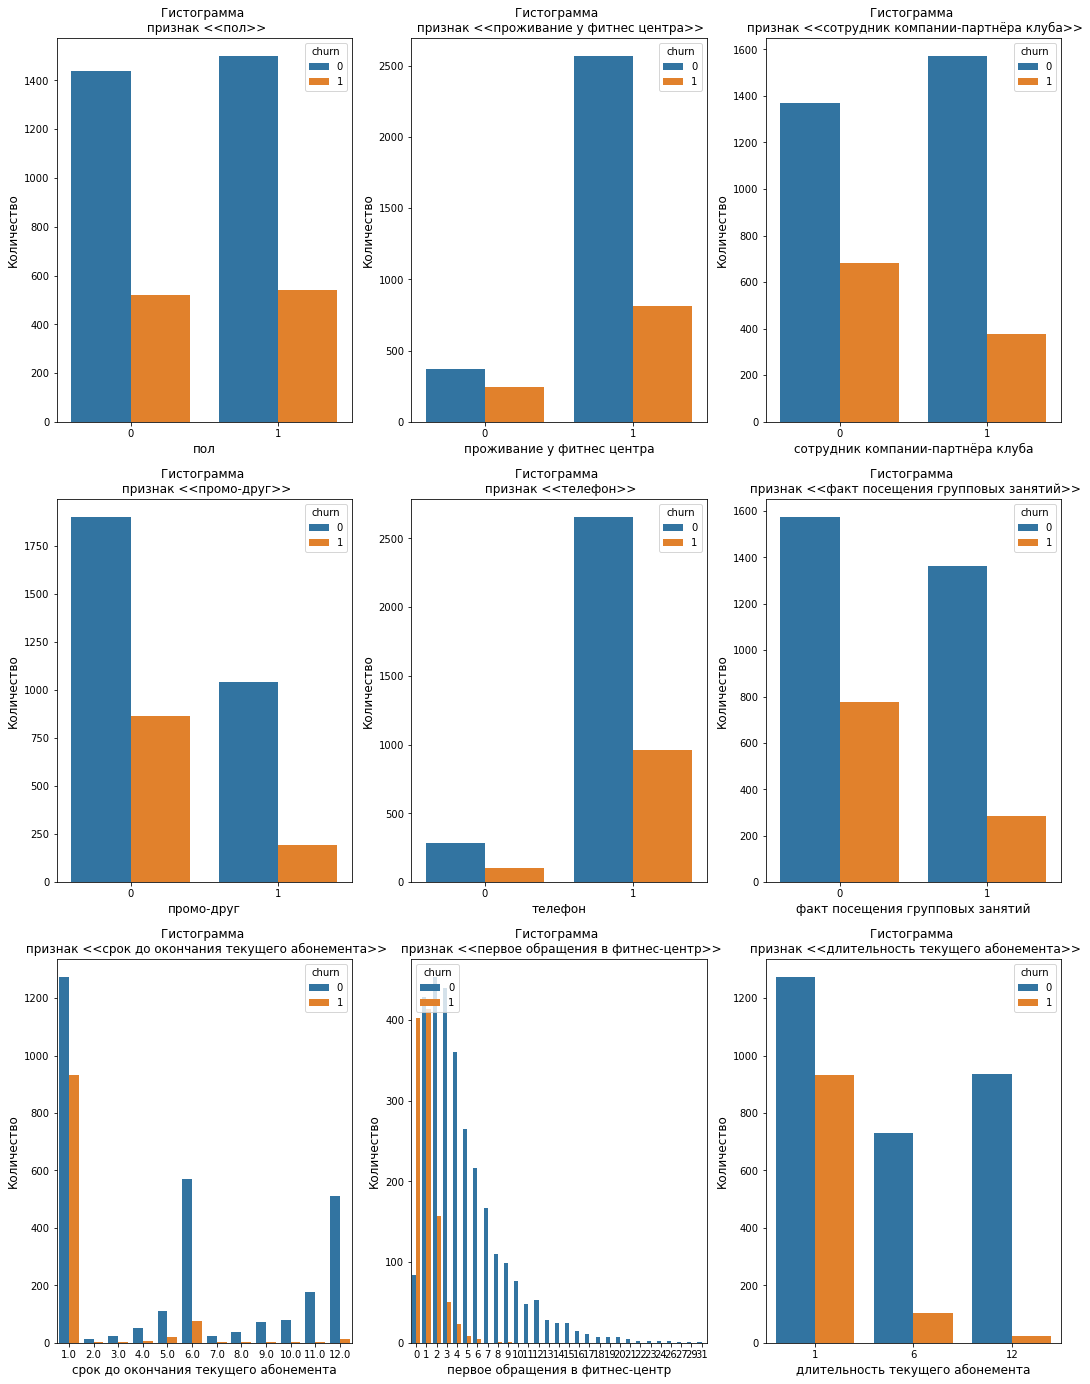

In [40]:
fig, axes = plt.subplots(3, sharey=True, figsize=(18,24))
i=0
for i, col in enumerate(cat_var):
    plt.subplot(3,3,i+1)
    ax = sns.countplot(x=col, hue='churn', data=df)
    plt.title("Гистограмма \n признак <<{}>>".format(dict_to_rus[col]))
    plt.xlabel(dict_to_rus[col], fontsize = 12)
    plt.ylabel('Количество', fontsize = 12)
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        #ax.annotate('{:d}'.format(p.get_height()), 
            #(x.mean(), y),ha='center', va='bottom', fontsize = 10)

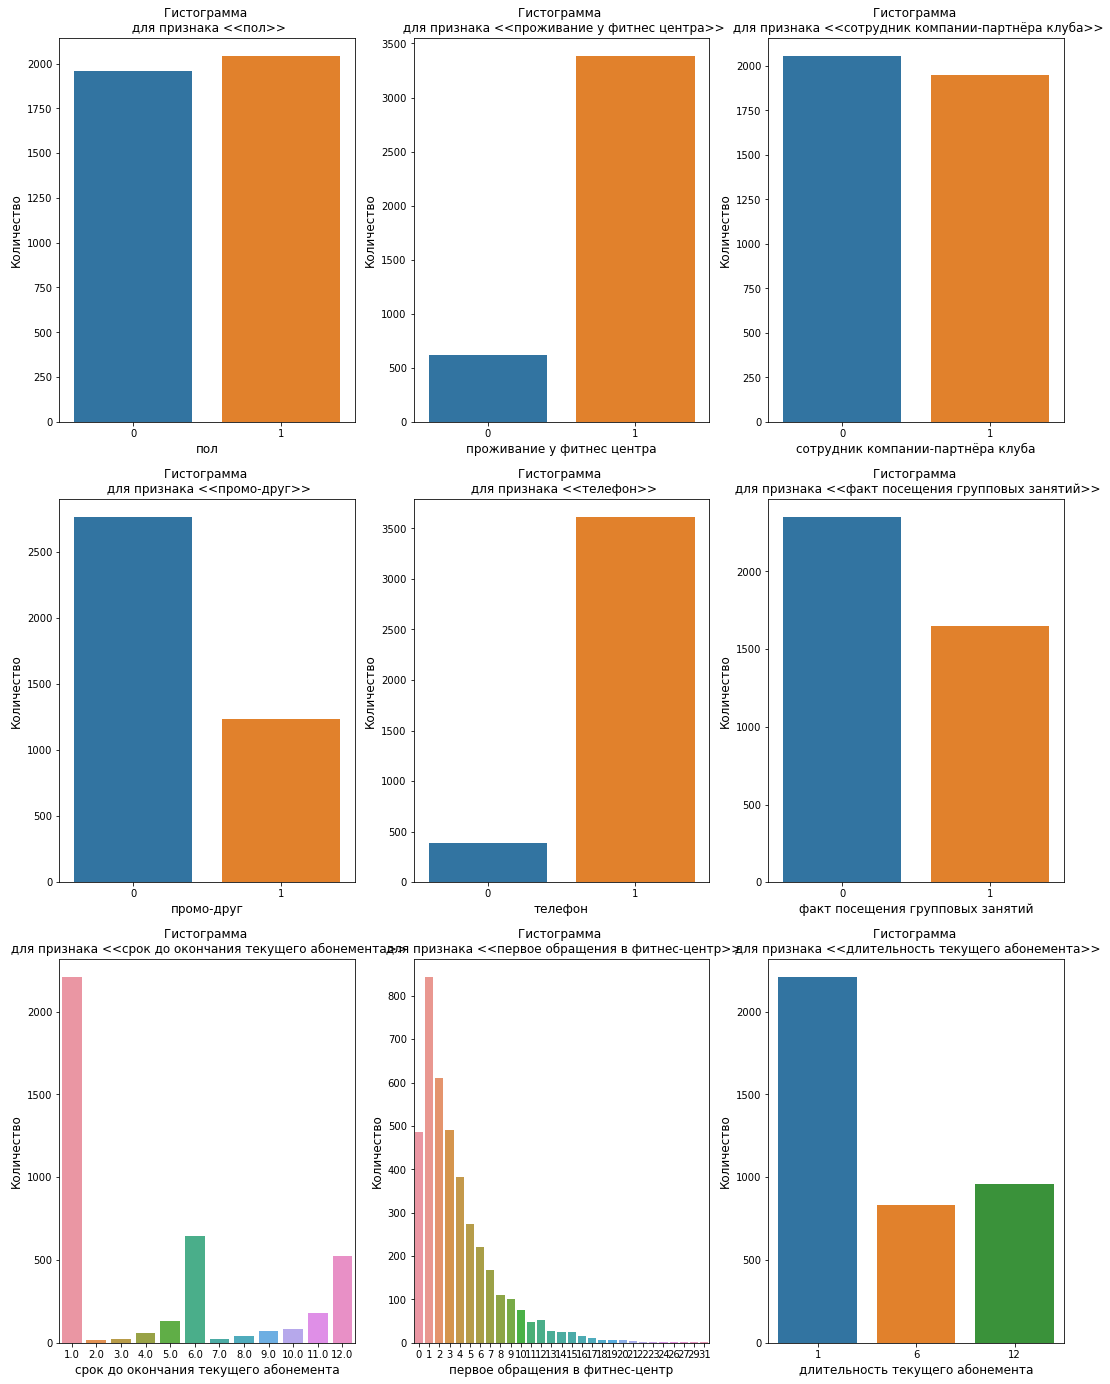

In [23]:
fig, axes = plt.subplots(3, sharey=True, figsize=(18,24))
i=0
for i, col in enumerate(cat_var):
    plt.subplot(3,3,i+1)
    ax = sns.countplot(x=col, data=df)
    plt.title("Гистограмма \n для признака <<{}>>".format(dict_to_rus[col]))
    plt.xlabel(dict_to_rus[col], fontsize = 12)
    plt.ylabel('Количество', fontsize = 12)
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        #ax.annotate('{:d}'.format(p.get_height()), 
            #(x.mean(), y),ha='center', va='bottom', fontsize = 10)

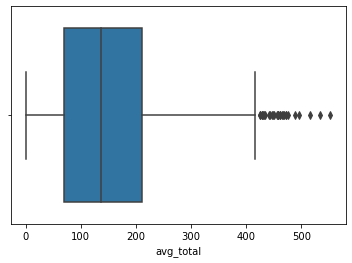

In [38]:

ax = sns.boxplot(x=df["avg_total"])

plt.show()

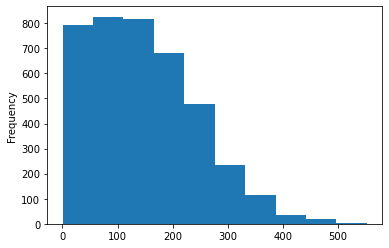

In [30]:
ax=df['avg_total'].plot(kind='hist')
plt.show()

из преведенных гистограмм можно сделать следующие выводы:
    1. gend- гендерного различия между ущедшими клиентами и оставшимися нет
    2. location- признак проживания имеет существенное значение. В процентном соотношении, клиентов живущих дальше ушло больше , чем живущих рядо с клубом.
    3. 'partner'- количество клиентов фитнес клуба , которые являются сотрудниками компании- пратнера, меньше, чем просто клинтов фитнес клуба.
    4.p_friends- В процентном соотношении, клиенты которые пришли по промокоду, меньше покидали фитнес центр
    5.phone- отсутствие  телефона существенно влияет на оток клиентов
    6.g_visits-факт посещения групповых занятий влияет на то, что клиенты задерживаются в клубе
    7.end_contract- ничего существенного сказать нельзя
    8.lifetime- большая часть клиентов уходит в первые 3 месяца
    

Портрет среднего постоянного клиента  фитнес-клуба: Средний возраст 30 лет, который посещает групповые занятия и тратит в среднем на допуслуги 158.44 ус.ед. При этом он живет в шаговой доступности от фитнес-клуба и возможно пришел по промо-коду или является сотрудникам компании-партнера клуба и посещает клуб более 6 месяцев 
Портрет среднего клинета фитнес-клуба, которы й ушел из клуба: средний возраст 27 лет и не старше 38, который не посещает групповые занятия, в среднем тратит  на 30% меньше на доп услуги в клубе
    

In [42]:
int_var = ['age', 'avg_total','frequency_week','frequency_current_month']

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gend                     4000 non-null   int64  
 1   location                 4000 non-null   int64  
 2   partner                  4000 non-null   int64  
 3   p_friends                4000 non-null   int64  
 4   phone                    4000 non-null   int64  
 5   con_period               4000 non-null   int64  
 6   g_visits                 4000 non-null   int64  
 7   age                      4000 non-null   int64  
 8   avg_total                4000 non-null   float64
 9   end_contract             4000 non-null   float64
 10  lifetime                 4000 non-null   int64  
 11  frequency_current_month  4000 non-null   float64
 12  frequency_week           4000 non-null   float64
 13  churn                    4000 non-null   int64  
dtypes: float64(4), int64(10)

C:\Users\katerina\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\katerina\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\katerina\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

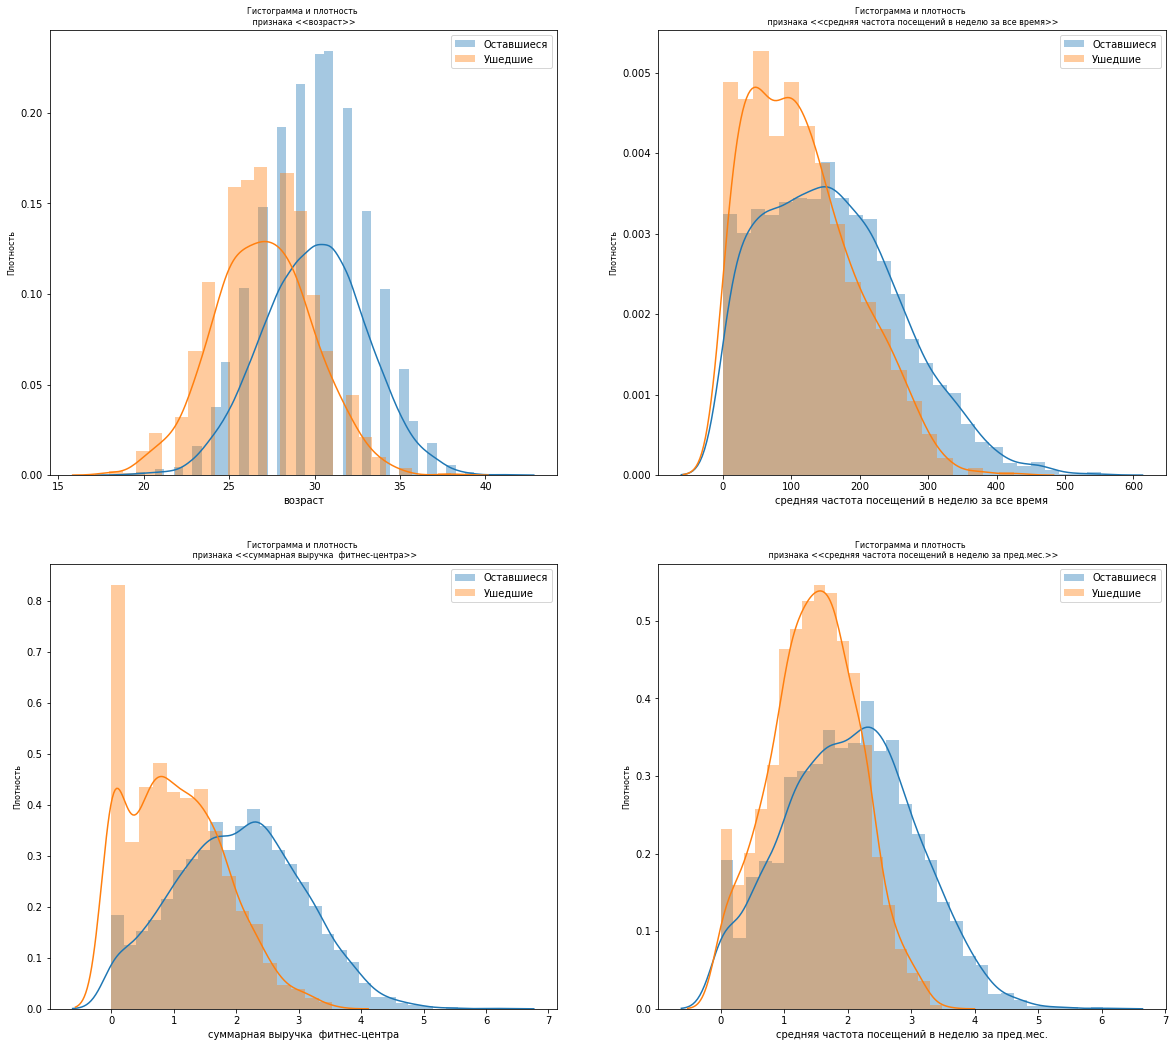

In [47]:
fig, axes = plt.subplots(2, 1, sharey=True, figsize=(20,18))
i=0
for i, col in enumerate(int_var):
    plt.subplot(2,2,i+1)
    ax = sns.distplot(df[df.churn == 0][col], label = 'Оставшиеся', )
    ax = sns.distplot(df[df.churn == 1][col], label = 'Ушедшие')
    plt.title("Гистограмма и плотность \n признака <<{}>>".format(dict_to_rus[col]),fontsize = 8)
    plt.xlabel(dict_to_rus[col], fontsize = 10)
    plt.ylabel('Плотность', fontsize = 8)
    plt.legend()

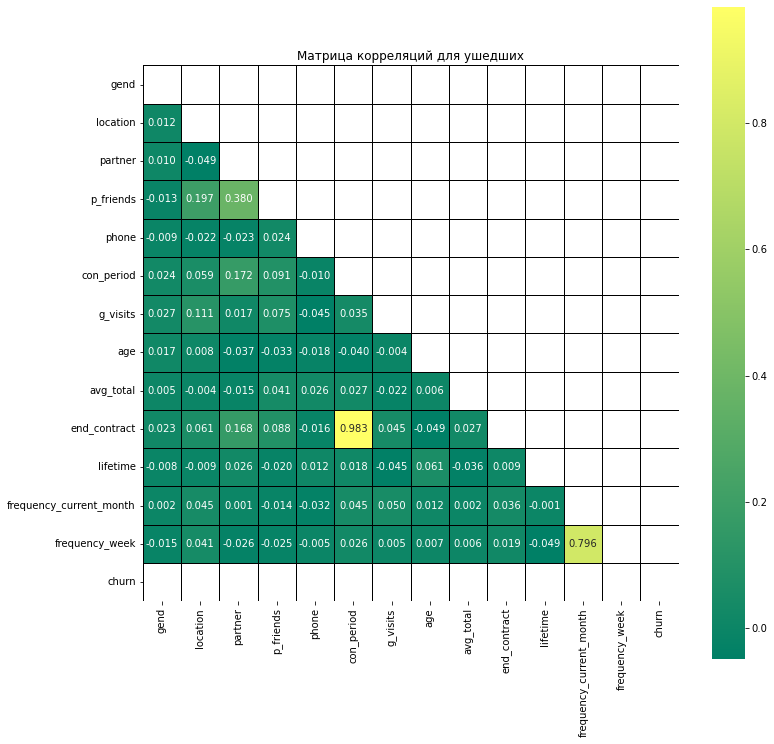

In [32]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(data = df1.corr(), annot=True, square=True, 
            cmap='summer', fmt='.3f', linewidths=1, linecolor='black', mask=np.triu(df.corr()))
plt.title('Матрица корреляций для ушедших')
plt.show()

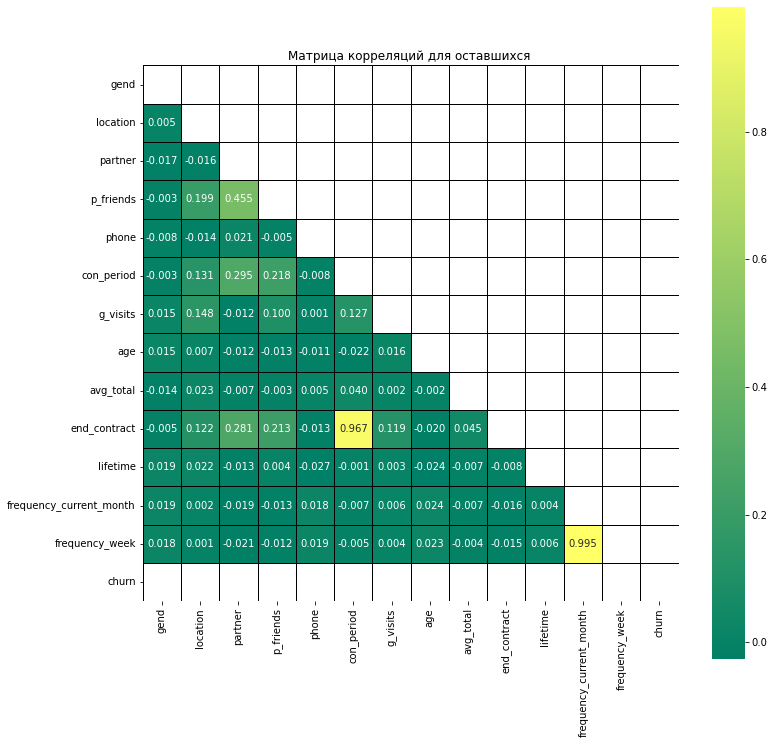

In [31]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(data = df0.corr(), annot=True, square=True, 
            cmap='summer', fmt='.3f', linewidths=1, linecolor='black', mask=np.triu(df.corr()))
plt.title('Матрица корреляций для оставшихся ')
plt.show()

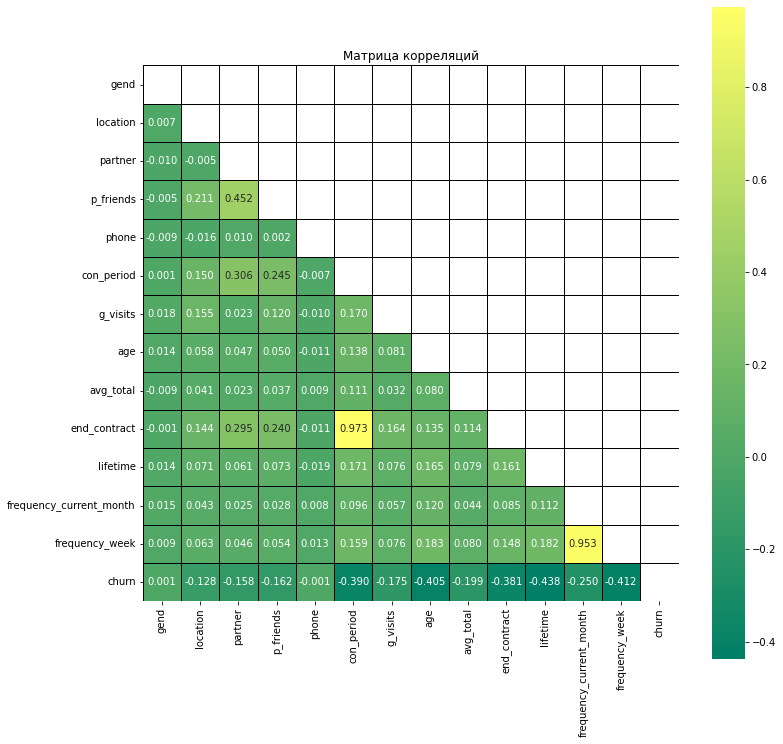

In [16]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(data = df.corr(), annot=True, square=True, 
            cmap='summer', fmt='.3f', linewidths=1, linecolor='black', mask=np.triu(df.corr()))
plt.title('Матрица корреляций')
plt.show()

# выводы по матрице кореляции:
1.признак churn  имеет слабую обратную связь с признаками age(-0.4), lifetime(-0.4), frequency_week(-0.4)
2. признаки frequency_week и frequency_curent_month имеют сильную положительную связь (0,95)
3. признаки con_period  и end_contract имеют сильную положительную связь (0,97)
4. признаки con_period и pertner имеют слабую положительную связь (0,3)
4. признаки p_friends и pertner имеют слабую положительную связь (0,45)

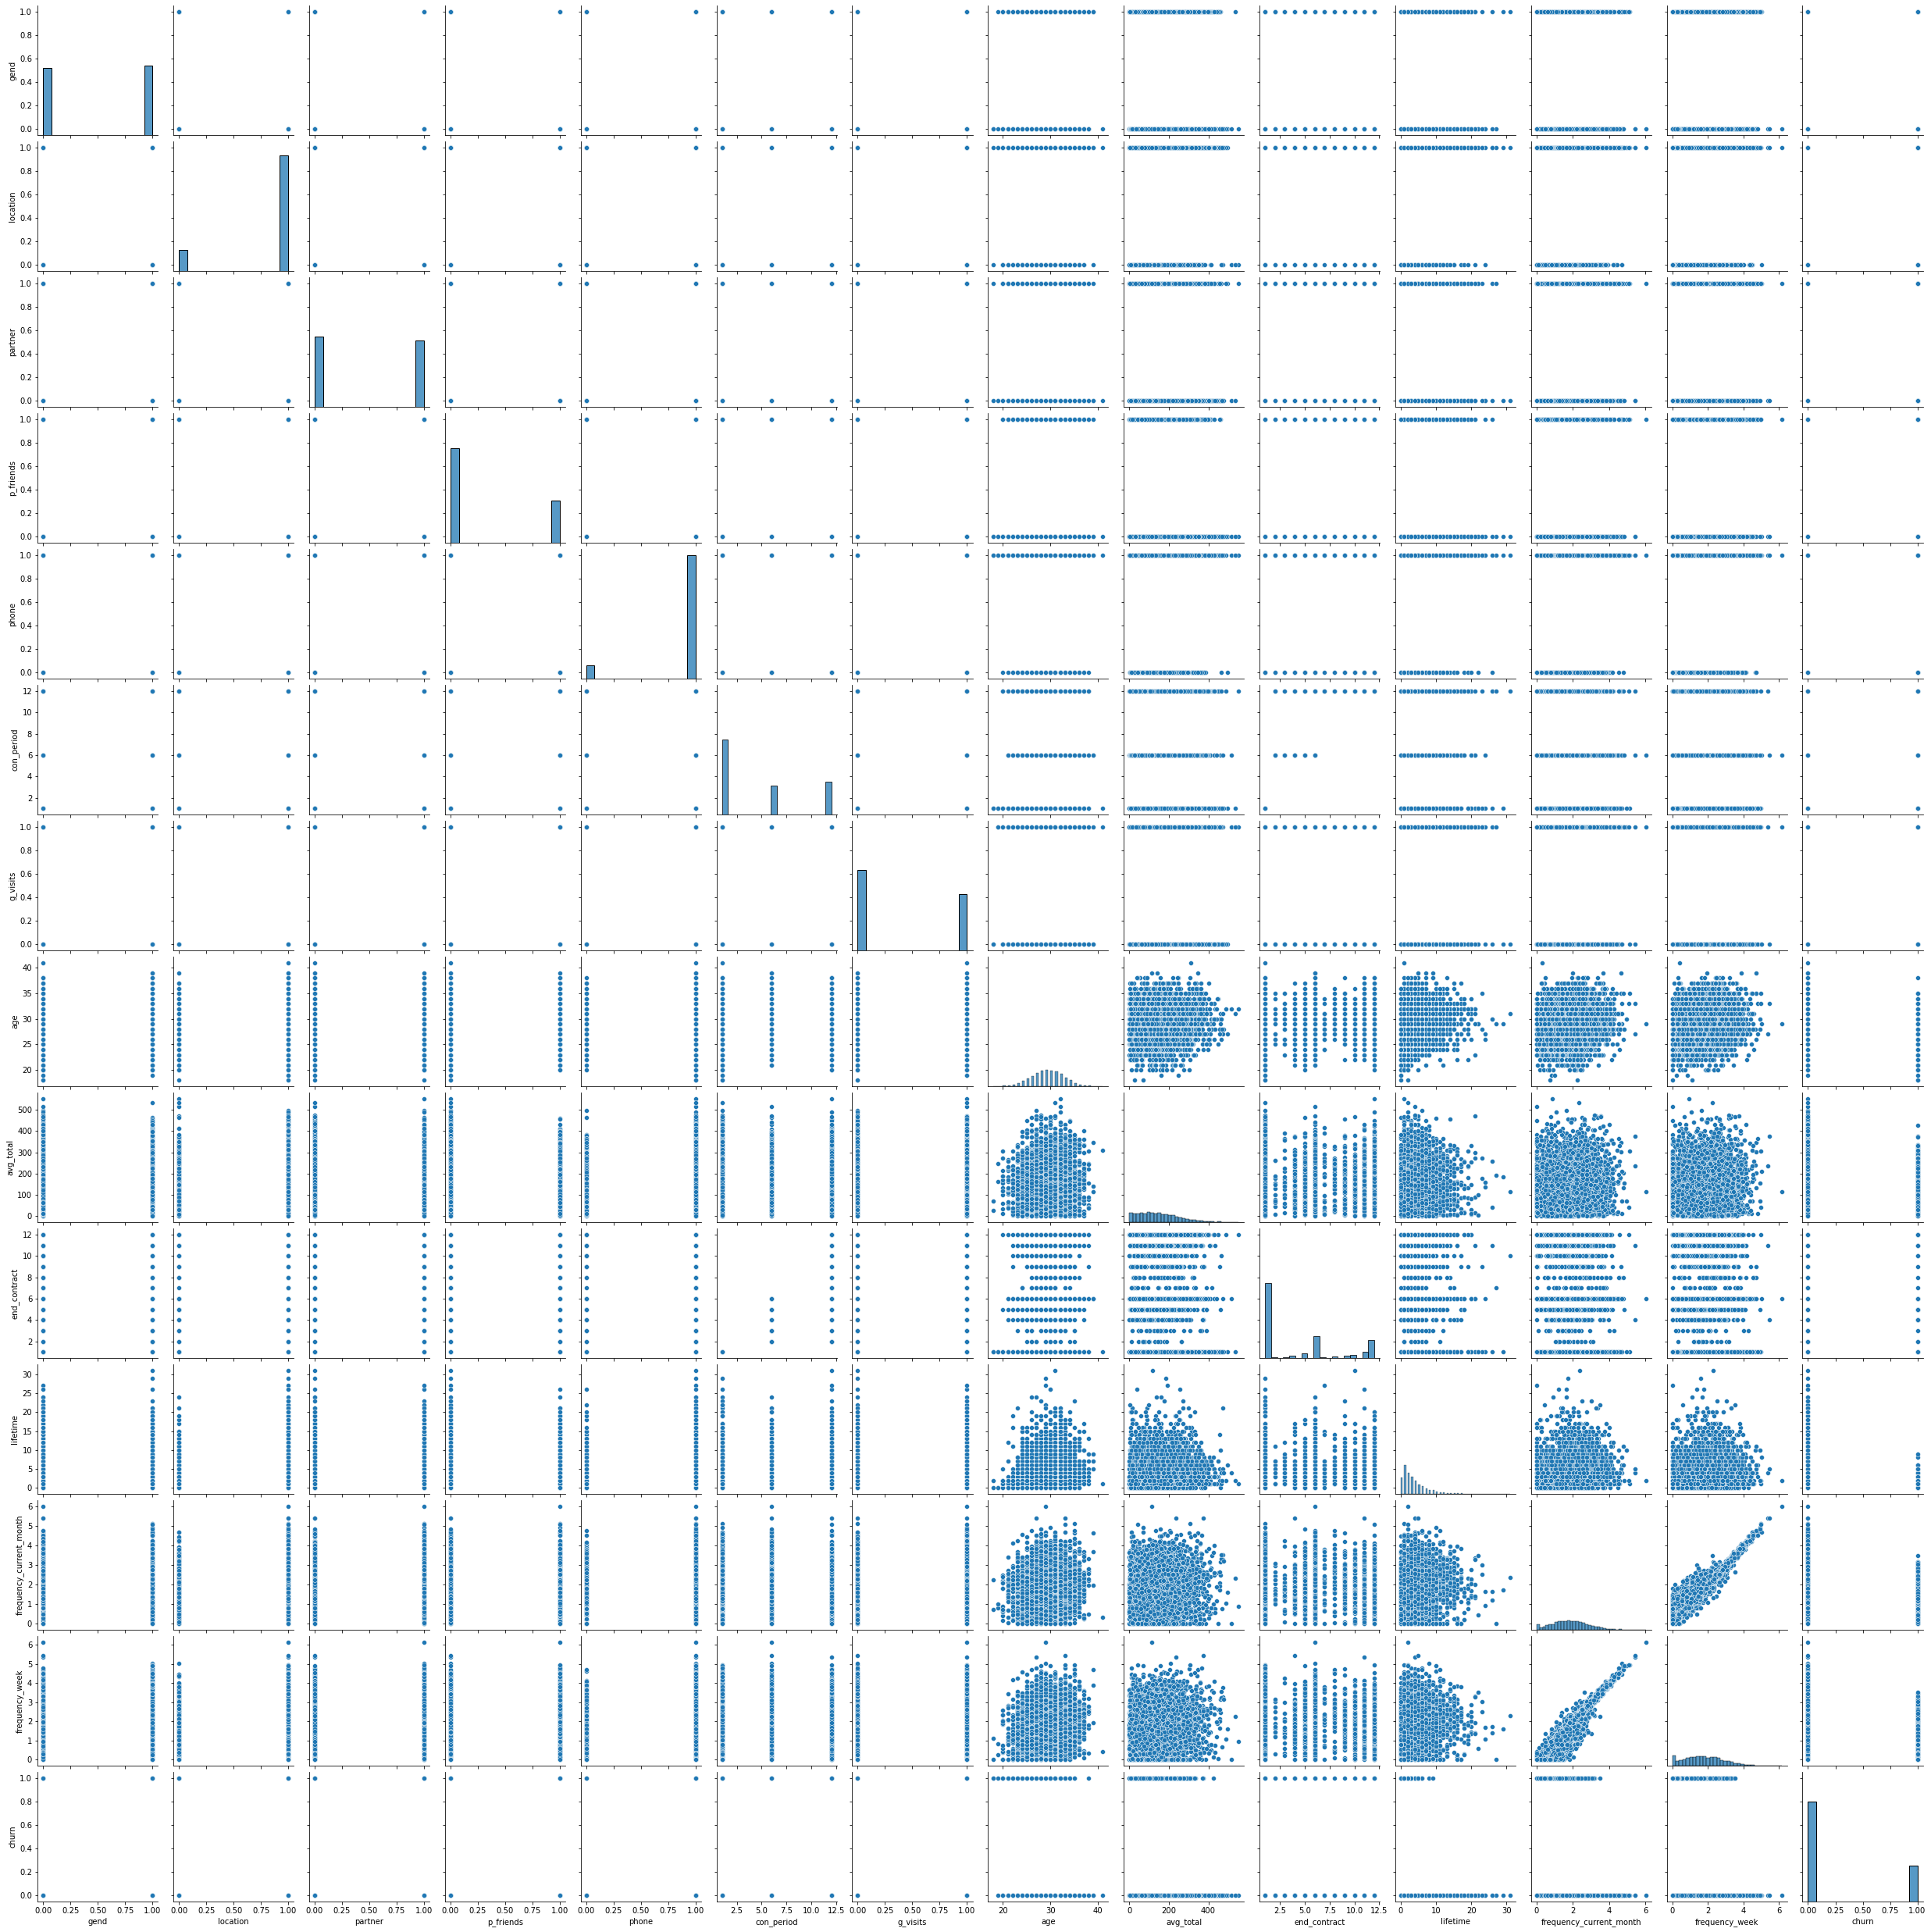

In [57]:
sns_plot = sns.pairplot(df)

In [ ]:
Визуализация категориальных признаков датафрейма

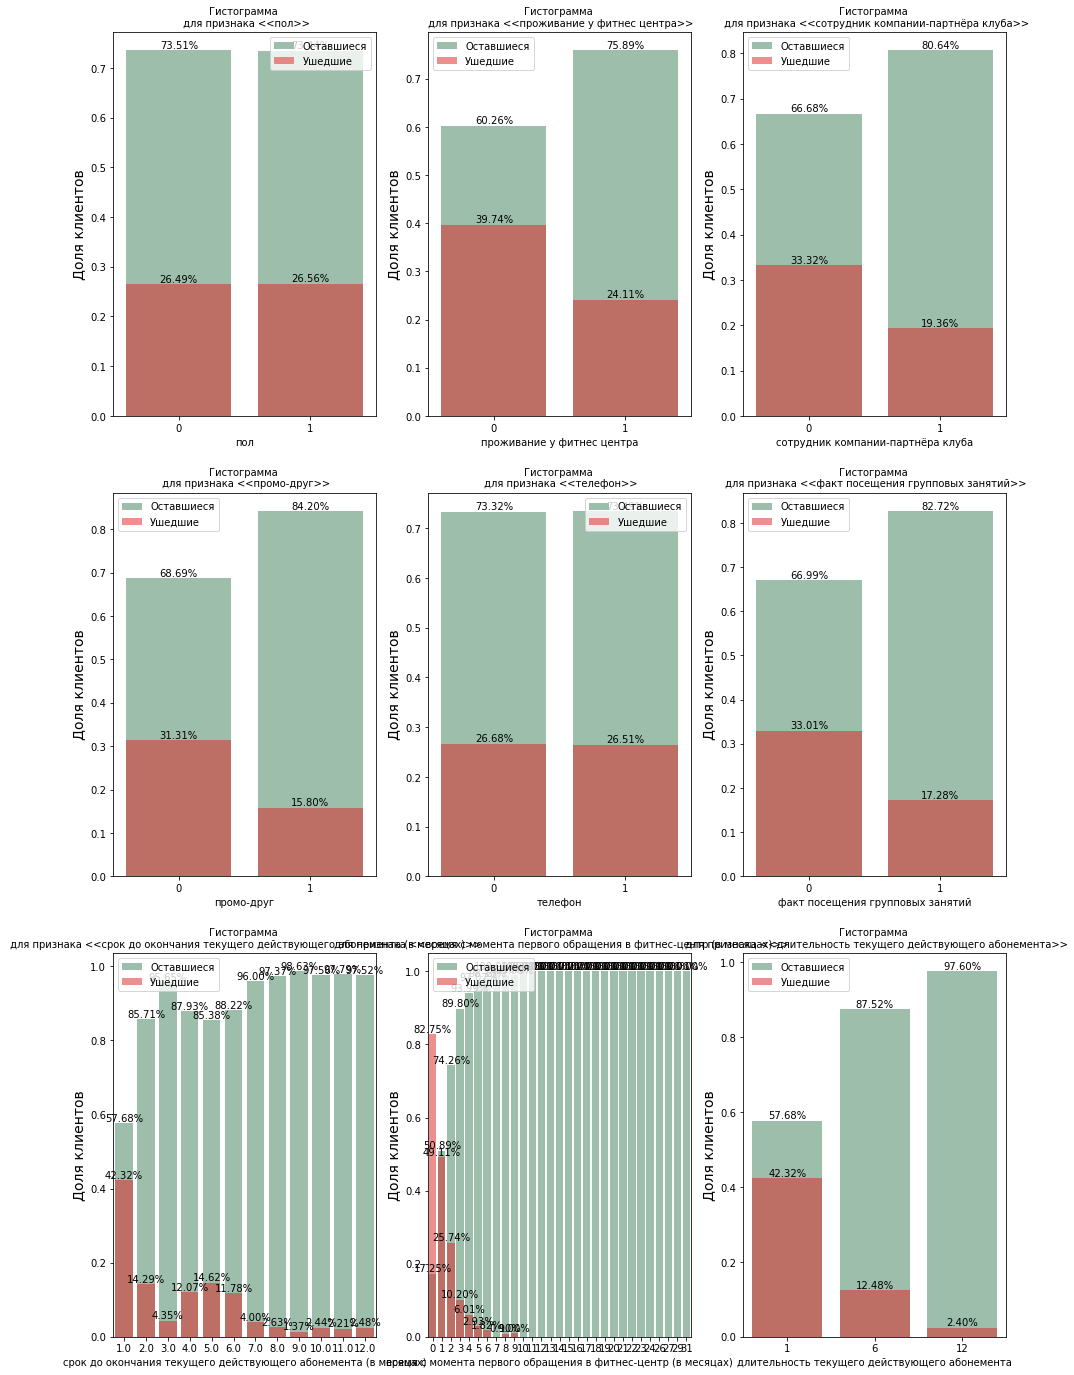

In [23]:
fig, axes = plt.subplots(3, figsize=(16,24))
i=0
for i, col in enumerate(cat_var):
    plt.subplot(3,3,i+1)
    data_all = df[col].value_counts()
    r = (pd.DataFrame([df[df.churn == 0][col].value_counts()/data_all, 
              df[df.churn == 1][col].value_counts()/data_all]).T)
    r.columns = ['0','1']
    ax1 = sns.barplot(x = r.index, y = r['0'], data = r, color='seagreen',
                      alpha = 0.5, label = 'Оставшиеся')
    ax2 = sns.barplot(x = r.index, y = r['1'], data = r, color='red', 
                      alpha = 0.5, label = 'Ушедшие')
    plt.title("Гистограмма \n для признака <<{}>>".format(dict_to_rus[col]), fontsize = 10)
    plt.xlabel(dict_to_rus[col], fontsize = 10)
    plt.ylabel('Доля клиентов', fontsize = 14)
    plt.legend()
    for p in ax1.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax1.annotate('{:.2f}%'.format(100*y), 
            (x.mean(), y),ha='center', va='bottom', fontsize = 10)


признаки пол и телефон не имеют значения

In [7]:
int_var2 = ['age', 'avg_total']

In [45]:
df['frequency_current_month'].unique()

array([0.02039795, 1.92293606, 1.85909835, ..., 2.78614636, 1.63010814,
       1.10183221])

In [ ]:
cat_var2 = ['gend','location', 'partner', 'p_friends', 'phone', 'g_visits','end_contract','lifetime','con_period']

In [39]:
w=df['frequency_week']/((df['frequency_current_month'])+1)
w

0       0.000000
1       0.653536
2       0.607360
3       0.798266
4       0.529867
          ...   
3995    0.715199
3996    0.128607
3997    0.747842
3998    0.606909
3999    0.492556
Length: 4000, dtype: float64

In [26]:
w1=df['end_contract']/df['con_period']
w1

0       0.833333
1       1.000000
2       1.000000
3       1.000000
4       1.000000
          ...   
3995    1.000000
3996    1.000000
3997    0.916667
3998    0.833333
3999    1.000000
Length: 4000, dtype: float64

In [59]:

int_var1={'w':w,
        'w1':w1,
         'age':df['age'],
          'avg_total':df['avg_total'],
          'location':df['location'],
          'partner':df['partner'],
          'p_friends':df['p_friends'],
          'phone':df['phone'],
          'g_visits':df['g_visits'],          
          'churn':df['churn']                  
         }
int_var2={'w':w,
         'w1':w1,              
         
                   
          'churn':df['churn']                  
         }

new_df=pd.DataFrame(int_var2)

#new_df.info()

new_df.head(2)

#ax = sns.distplot(new_df[new_df.churn == 0][col], label = 'Оставшиеся')
#ax = sns.distplot(new_df[new_df.churn == 1][col], label = 'Ушедшие')

,w,w1,churn
0,0.000000,0.833333,0
1,0.653536,1.000000,0


In [57]:
new_df.describe()

,w1,churn
count,4000.000000,4000.000000
mean,0.963458,0.265250
std,0.104785,0.441521
min,0.166667,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [48]:
new_df['w'].unique()

array([0.        , 0.65353586, 0.60735997, ..., 0.74784206, 0.60690913,
       0.49255585])

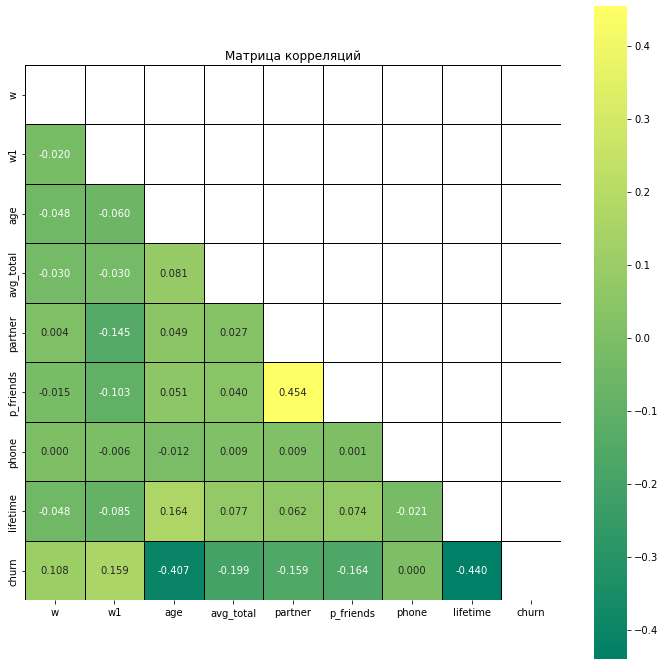

In [9]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(data = new_df.corr(), annot=True, square=True, 
            cmap='summer', fmt='.3f', linewidths=1, linecolor='black', mask=np.triu(new_df.corr()))
plt.title('Матрица корреляций')
plt.show()

C:\Users\katerina\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\katerina\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


KeyError: 'w'

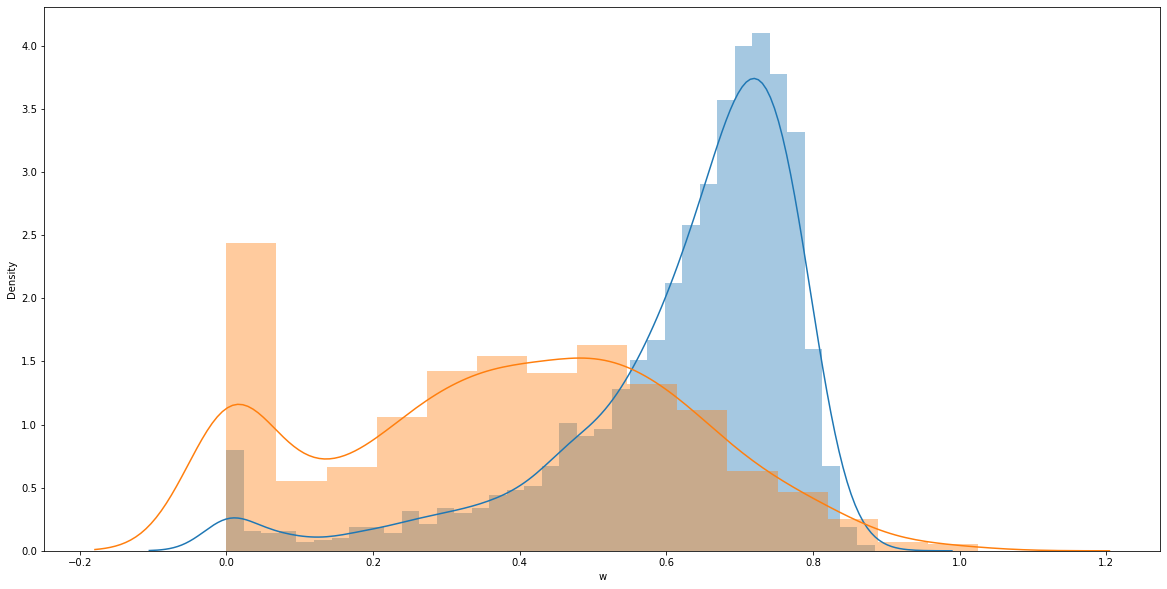

In [60]:
fig, axes = plt.subplots(1, 1, sharey=True, figsize=(20,10))
i=0
for i, col in enumerate(int_var2):
    plt.subplot(1,1,i+1)
    ax = sns.distplot(new_df[new_df.churn == 0][col], label = 'Оставшиеся', )
    ax = sns.distplot(new_df[new_df.churn == 1][col], label = 'Ушедшие')
    plt.title("Гистограмма и плотность \n для признака <<{}>>".format(dict_to_rus[col]),fontsize = 8)
    plt.xlabel(dict_to_rus[col], fontsize = 10)
    plt.ylabel('Плотность', fontsize = 8)
    plt.legend()

In [85]:
new_df['w'].unique()

array([0.        , 0.9933994 , 0.93405596, ..., 1.01625655, 0.97922131,
       0.9395893 ])

w        0
w1       0
churn    0
dtype: int64

OverflowError: cannot convert float infinity to integer

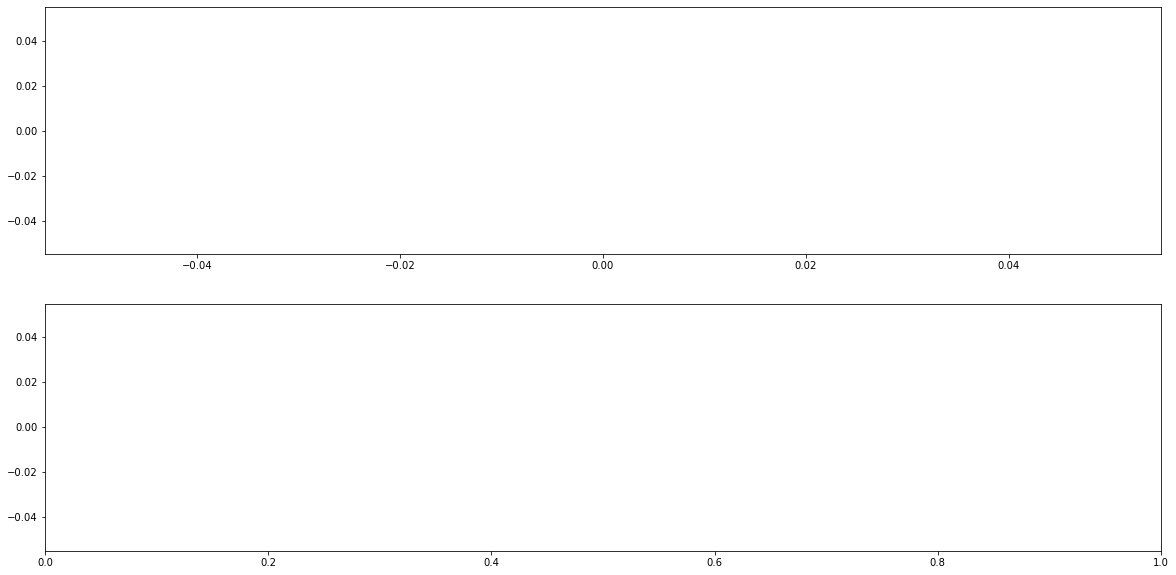

In [76]:
fig, axes = plt.subplots(2, 1, sharey=True, figsize=(20,10))
i=0
for i, col in enumerate(int_var1):
    plt.subplot(2,2,i+1)
    ax = sns.distplot(new_df[new_df.churn == 0][col], label = 'Оставшиеся', )
    ax = sns.distplot(new_df[new_df.churn == 1][col], label = 'Ушедшие')
    plt.title("Гистограмма и плотность \n для признака <<{}>>".format(dict_to_rus[col]),fontsize = 8)
    plt.xlabel(dict_to_rus[col], fontsize = 10)
    plt.ylabel('Плотность', fontsize = 8)
    plt.legend()

In [24]:
profile=df.profile_report(title='Pandas Profiling Report', progress_bar=False)
profile.to_widgets()

# кластеризация клиентов

In [20]:
#создаем признаковое пространство
Pr_pr=['location','partner', 'p_friends', 'g_visits','lifetime','con_period','age', 'avg_total','frequency_week','churn']

In [39]:
df_cl=df[Pr_pr] # 
df_cl=df_cl[df_cl['churn']==1]

In [40]:
df_cl.head(1)

,location,partner,p_friends,g_visits,lifetime,con_period,age,avg_total,frequency_week,churn
7,1,0,0,0,0,1,30,217.786641,1.049387,1


In [41]:
X = df_cl.drop(['churn'], axis = 1)
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

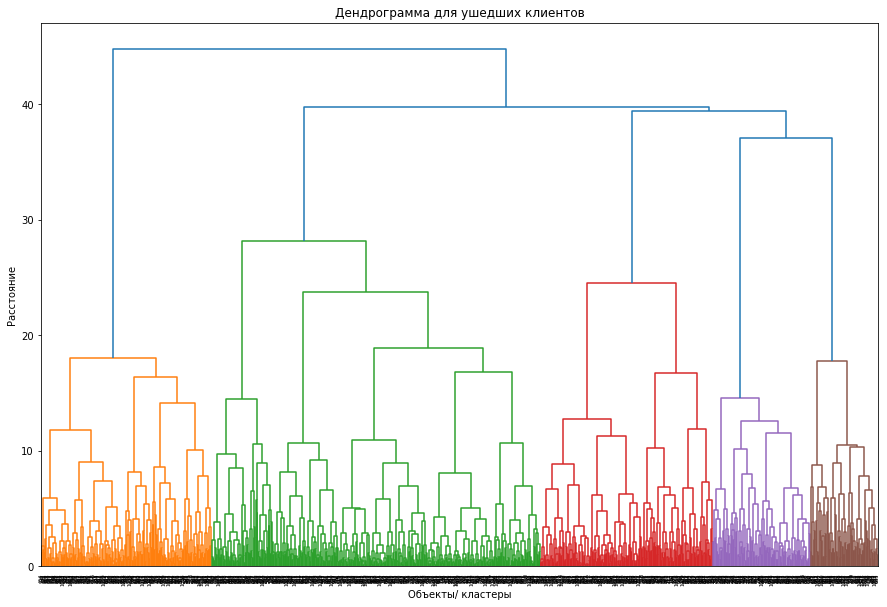

In [42]:
plt.figure(figsize=(15, 10))
Z = linkage(X_st, method='ward') 
plt.title('Дендрограмма для ушедших клиентов')
plt.xlabel('Объекты/ кластеры')
plt.ylabel('Расстояние')
dendrogram(Z, orientation='top')
plt.show();

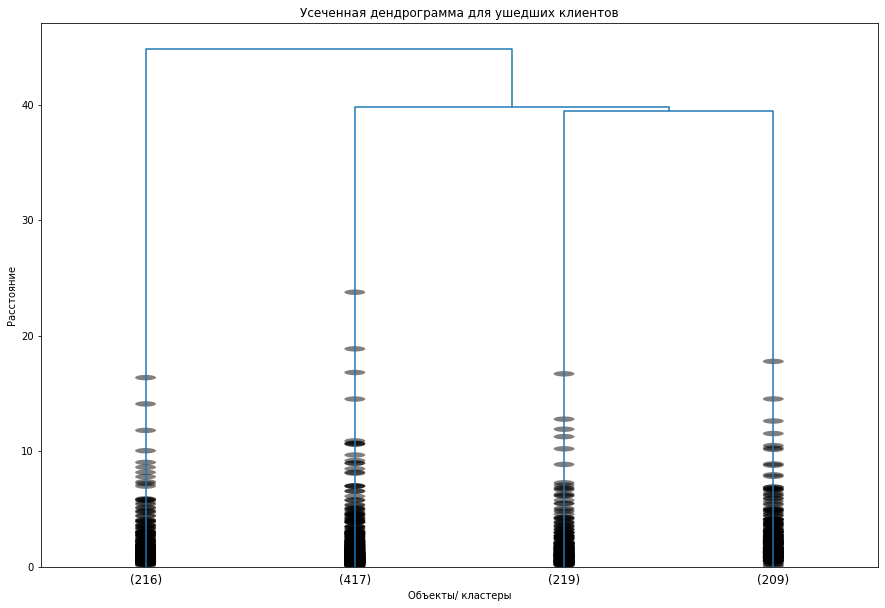

In [116]:
plt.figure(figsize=(15, 10))
dendrogram(Z, 
           truncate_mode = 'lastp',
           p=4,                    
           show_contracted = True)
plt.title('Усеченная дендрограмма для ушедших клиентов')
plt.xlabel('Объекты/ кластеры')
plt.ylabel('Расстояние')
plt.show();

In [47]:
agl_cluster_label = fcluster(Z, 5, criterion='maxclust')
agl_cluster_label

array([2, 2, 3, ..., 3, 2, 3], dtype=int32)

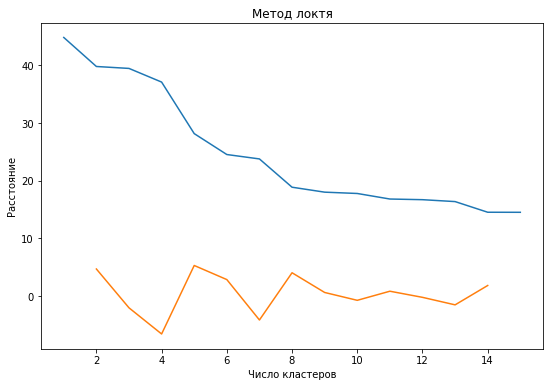

Оптимальное число кластеров: 5


In [120]:
plt.figure(figsize=(9, 6))
last = Z[-15:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1,1)
plt.xlabel('Число кластеров')
plt.ylabel('Расстояние')
plt.title('Метод локтя')
plt.plot(idxs, last_rev)
acceleration = np.diff(last, 2)
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2
print("Оптимальное число кластеров:", k)

Промежуточный вывод по иерархической кластеризации: Проведена иерархическая кластеризация, результаты которой представлены в виде дендрограммы. Выделяется 4 кластера и это хорошо согласуется с методом "локтя". Запомнили метки кластеров для объектов (клиентов).

In [43]:
km = KMeans(n_clusters =5, random_state = 42)
notagl_cluster_label = km.fit_predict(X_st)

In [48]:
type(notagl_cluster_label)
type(agl_cluster_label)

numpy.ndarray

In [49]:
len(notagl_cluster_label)

1061

In [50]:
df_ml_churn = pd.DataFrame(df_cl)
df_ml_churn['agl_cluster_label'] = agl_cluster_label
df_ml_churn['notagl_cluster_label'] = notagl_cluster_label

In [123]:
#df_ml_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1061 entries, 7 to 3996
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   location              1061 non-null   int64  
 1   partner               1061 non-null   int64  
 2   p_friends             1061 non-null   int64  
 3   g_visits              1061 non-null   int64  
 4   lifetime              1061 non-null   int64  
 5   con_period            1061 non-null   int64  
 6   age                   1061 non-null   int64  
 7   avg_total             1061 non-null   float64
 8   frequency_week        1061 non-null   float64
 9   churn                 1061 non-null   int64  
 10  agl_cluster_label     1061 non-null   int32  
 11  notagl_cluster_label  1061 non-null   int32  
dtypes: float64(2), int32(2), int64(8)
memory usage: 99.5 KB


In [53]:
df_ml1=df_ml_churn.groupby('agl_cluster_label')['agl_cluster_label'].count()
df_ml1

agl_cluster_label
1    216
2    417
3    219
4    124
5     85
Name: agl_cluster_label, dtype: int64

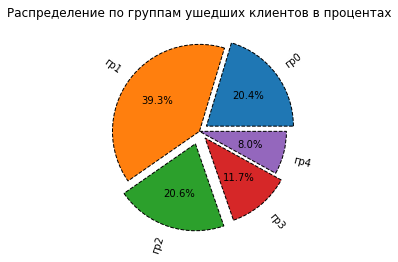

In [67]:
labels = ["гр0", "гр1", "гр2", "гр3", "гр4"]
explode = (0.1, 0, 0.15, 0.1, 0)
ax = plt.pie(df_ml1,  autopct='%1.1f%%',labels=labels,shadow=False,explode=explode,wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"},rotatelabels=True)
plt.title('Распределение по группам ушедших клиентов в процентах')
plt.show()

In [108]:
rating_cluster = df_ml_churn.groupby('agl_cluster_label').mean().reset_index().sort_values(by = 'churn', ascending = False)
rating_cluster.T

,1,2,0
agl_cluster_label,2.000000,3.000000,1.000000
location,0.000000,0.996542,1.000000
partner,0.495922,0.016138,0.977603
p_friends,0.081566,0.102594,0.608959
g_visits,0.233279,0.444380,0.444915
lifetime,2.947798,3.873775,3.856538
con_period,3.061990,3.608069,6.409201
age,28.743883,29.168300,29.364407
avg_total,136.721488,145.614136,152.133240
frequency_week,1.611995,1.776258,1.814919


In [109]:
rating_cluster_k_means = df_ml_churn.groupby('notagl_cluster_label').mean().reset_index().sort_values(by = 'churn', ascending = False)
rating_cluster_k_means.T

,2,0,1
notagl_cluster_label,2.000000,0.000000,1.000000
location,0.000000,1.000000,0.997179
partner,0.489431,0.165226,0.931594
p_friends,0.074797,0.062023,0.751763
g_visits,0.234146,0.393493,0.515515
lifetime,3.068293,3.253177,4.663611
con_period,3.045528,3.027453,7.684767
age,28.713821,28.954245,29.707334
avg_total,137.450020,141.954072,157.982715
frequency_week,1.604212,1.679521,1.959097


 Кластеризация оставшихся клиентов

In [24]:
df_cl0=df[Pr_pr] # 
df_cl0=df_cl0[df_cl0['churn']==0]

In [25]:
X0 = df_cl0.drop(['churn'], axis = 1)
scaler = StandardScaler()
X0_st = scaler.fit_transform(X0)

In [73]:
X0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2939 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   location        2939 non-null   int64  
 1   partner         2939 non-null   int64  
 2   p_friends       2939 non-null   int64  
 3   g_visits        2939 non-null   int64  
 4   lifetime        2939 non-null   int64  
 5   con_period      2939 non-null   int64  
 6   age             2939 non-null   int64  
 7   avg_total       2939 non-null   float64
 8   frequency_week  2939 non-null   float64
dtypes: float64(2), int64(7)
memory usage: 229.6 KB


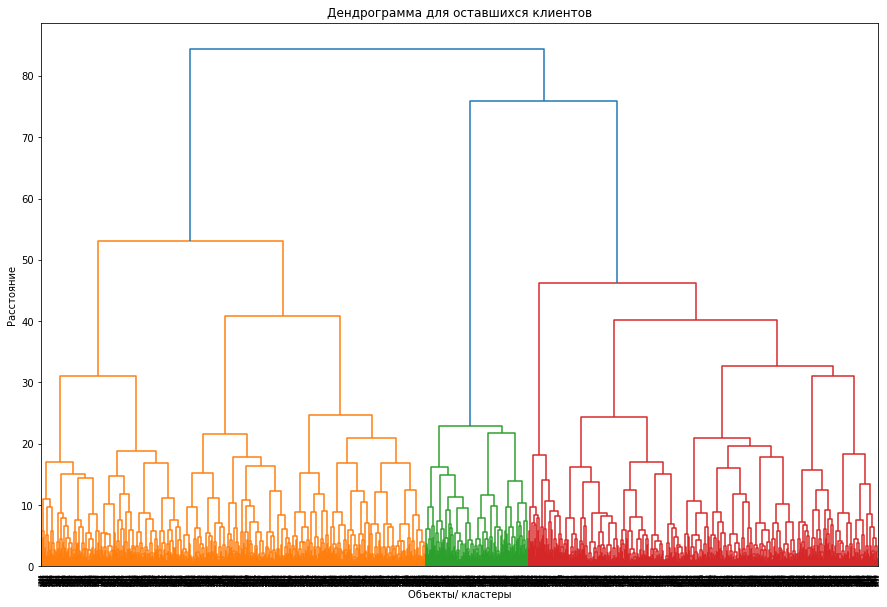

In [74]:
plt.figure(figsize=(15, 10))
Z0 = linkage(X0_st, method='ward') 
plt.title('Дендрограмма для оставшихся клиентов')
plt.xlabel('Объекты/ кластеры')
plt.ylabel('Расстояние')
dendrogram(Z0, orientation='top')
plt.show();

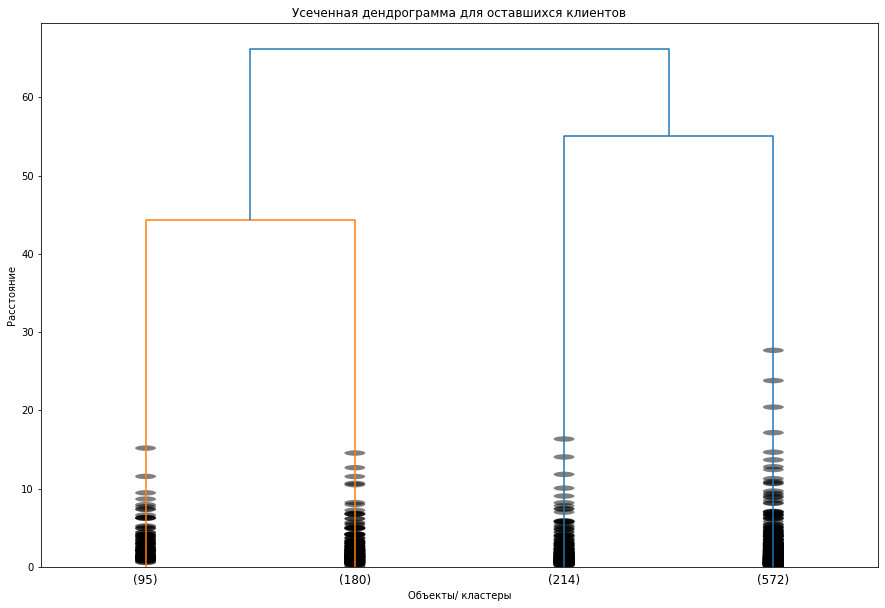

In [135]:
plt.figure(figsize=(15, 10))
dendrogram(Z0, 
           truncate_mode = 'lastp',
           p=4,                    
           show_contracted = True)
plt.title('Усеченная дендрограмма для оставшихся клиентов')
plt.xlabel('Объекты/ кластеры')
plt.ylabel('Расстояние')
plt.show();

In [75]:
agl_cluster_label0 = fcluster(Z0, 3, criterion='maxclust')
agl_cluster_label0

array([1, 3, 1, ..., 1, 1, 2], dtype=int32)

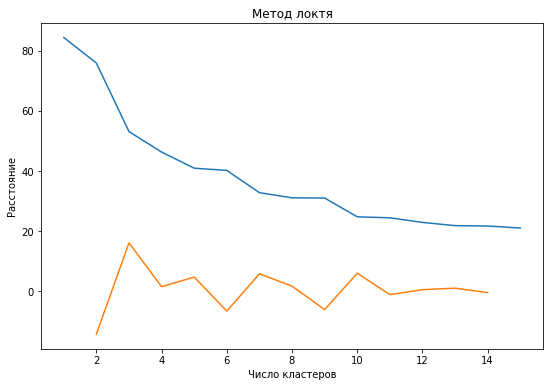

Оптимальное число кластеров: 3


In [29]:
plt.figure(figsize=(9, 6))
last = Z0[-15:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1,1)
plt.xlabel('Число кластеров')
plt.ylabel('Расстояние')
plt.title('Метод локтя')
plt.plot(idxs, last_rev)
acceleration = np.diff(last, 2)
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2
print("Оптимальное число кластеров:", k)

In [76]:
km0 = KMeans(n_clusters =3, random_state = 42)
notagl_cluster_label0 = km0.fit_predict(X0_st)

In [77]:
len(agl_cluster_label0)

2939

In [78]:
df_ml_churn0 = pd.DataFrame(df_cl0)
df_ml_churn0['agl_cluster_label0'] = agl_cluster_label0
df_ml_churn0['notagl_cluster_label0'] = notagl_cluster_label0

In [120]:
df_ml_churn0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2939 entries, 0 to 3999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   location                 2939 non-null   int64  
 1   partner                  2939 non-null   int64  
 2   p_friends                2939 non-null   int64  
 3   g_visits                 2939 non-null   int64  
 4   end_contract             2939 non-null   float64
 5   lifetime                 2939 non-null   int64  
 6   con_period               2939 non-null   int64  
 7   age                      2939 non-null   int64  
 8   avg_total                2939 non-null   float64
 9   frequency_week           2939 non-null   float64
 10  frequency_current_month  2939 non-null   float64
 11  churn                    2939 non-null   int64  
 12  agl_cluster_label        2939 non-null   int32  
 13  notagl_cluster_label     2939 non-null   int32  
 14  agl_cluster_label0      

In [79]:
df_ml0=df_ml_churn0.groupby('agl_cluster_label0')['agl_cluster_label0'].count()

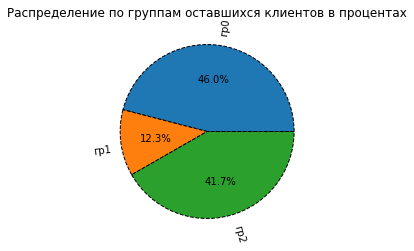

In [85]:
labels = ["гр0", "гр1", "гр2"]
explode = (0.1, 0, 0.1)
ax = plt.pie(df_ml0,  autopct='%1.1f%%',labels=labels,shadow=False,wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"},rotatelabels=True)
plt.title('Распределение по группам оставшихся клиентов в процентах')
plt.show()

In [83]:
rating_cluster = df_ml_churn0.groupby('agl_cluster_label0').mean().reset_index().sort_values(by = 'churn', ascending = False)
rating_cluster.T

,0,1,2
agl_cluster_label0,1.000000,2.000000,3.000000
location,1.000000,0.000000,0.991028
partner,0.985936,0.569061,0.026101
p_friends,0.632124,0.107735,0.119086
g_visits,0.495189,0.267956,0.487765
lifetime,4.501850,4.121547,5.117455
con_period,7.336788,4.151934,4.466558
age,29.897853,29.950276,30.070962
avg_total,160.794994,152.317565,157.666363
frequency_week,2.022784,2.034610,2.031513


In [86]:
rating_cluster_k_means = df_ml_churn0.groupby('notagl_cluster_label0').mean().reset_index().sort_values(by = 'churn', ascending = False)
rating_cluster_k_means.T

,0,1,2
notagl_cluster_label0,0.000000,1.000000,2.000000
location,1.000000,1.000000,0.000000
partner,0.968980,0.131245,0.554960
p_friends,0.716735,0.090977,0.104558
g_visits,0.512653,0.473527,0.270777
lifetime,4.633469,4.846383,4.485255
con_period,8.422857,3.753169,4.128686
age,29.908571,30.053691,29.922252
avg_total,159.414084,159.244559,152.393431
frequency_week,2.000872,2.053280,2.025277


#Cтатистическая значимость признаков 

In [105]:
stat, p = scipy.stats.shapiro(df0['avg_total'], df1['avg_total']) # тест Шапиро-Уилк
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

TypeError: shapiro() takes 1 positional argument but 2 were given

In [67]:
from statsmodels.stats.weightstats import ttest_ind

In [72]:
scipy.stats.ttest_ind(df0['age'],df1['age'])

Ttest_indResult(statistic=27.98595335238202, pvalue=1.5144442927601953e-157)

In [73]:
stat, p = scipy.stats.ttest_ind(df0['age'],df1['age']) # тест t-student
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о равенстве средних')
else:
    print('Отклонить гипотезу о равенстве средних')

Statistics=27.986, p-value=0.000
Отклонить гипотезу о равенстве средних


In [74]:
stat, p = scipy.stats.ttest_ind(df0['avg_total'],df1['avg_total']) # тест t-student
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о равенстве средних')
else:
    print('Отклонить гипотезу о равенстве средних')

Statistics=12.819, p-value=0.000
Отклонить гипотезу о равенстве средних


In [ ]:
w=df['frequency_week']/((df['frequency_current_month'])+1)

In [75]:
stat, p = scipy.stats.ttest_ind(df0['frequency_current_month'],df1['frequency_current_month']) # тест t-student
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о равенстве средних')
else:
    print('Отклонить гипотезу о равенстве средних')

Statistics=16.306, p-value=0.000
Отклонить гипотезу о равенстве средних


In [77]:
stat, p = scipy.stats.ttest_ind(df0['frequency_week'],df1['frequency_week']) # тест t-student
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о равенстве средних')
else:
    print('Отклонить гипотезу о равенстве средних')

Statistics=28.619, p-value=0.000
Отклонить гипотезу о равенстве средних


In [80]:
new_df0=new_df[new_df['churn']==0]
new_df1=new_df[new_df['churn']==1]

In [83]:
stat, p = scipy.stats.ttest_ind(new_df0['w'],new_df1['w'])# тест t-student
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о равенстве средних')
else:
    print('Отклонить гипотезу о равенстве средних')

Statistics=34.582, p-value=0.000
Отклонить гипотезу о равенстве средних


In [84]:
stat, p = scipy.stats.ttest_ind(new_df0['w1'],new_df1['w1'])# тест t-student
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о равенстве средних')
else:
    print('Отклонить гипотезу о равенстве средних')


Statistics=-10.131, p-value=0.000
Отклонить гипотезу о равенстве средних


In [85]:
new_df0.describe()

,w,w1,churn
count,2939.000000,2939.000000,2939.0
mean,0.619755,0.953499,0.0
std,0.172940,0.116346,0.0
min,0.000000,0.166667,0.0
25%,0.561564,1.000000,0.0
50%,0.671514,1.000000,0.0
75%,0.736688,1.000000,0.0
max,0.884392,1.000000,0.0


In [86]:
new_df1.describe()

,w,w1,churn
count,1061.000000,1061.000000,1061.0
mean,0.380435,0.991046,1.0
std,0.240669,0.053552,0.0
min,0.000000,0.333333,1.0
25%,0.205493,1.000000,1.0
50%,0.396347,1.000000,1.0
75%,0.557184,1.000000,1.0
max,1.025055,1.000000,1.0


In [92]:
from statsmodels.stats import weightstats as stests

гипотеза HO-среднее по признаку пол не различимы
         H1-среднее по признаку пол  различимы

In [97]:
ztest ,p = stests.ztest(df0['gend'], df1['gend'], value=0,alternative='two-sided')
print(float(p))
if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

0.9643067013359539
accept null hypothesis


гипотеза HO-среднее по признаку партнер не различимы
         H1-среднее по признаку пол  различимы

In [96]:
ztest ,p = stests.ztest(df0['partner'], df1['partner'], value=0,alternative='two-sided')
print(float(p))
if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

4.670707450429604e-24
reject null hypothesis


гипотеза HO-среднее по признаку время жизни не различимы
         H1-среднее по признаку пол  различимы

In [98]:
ztest ,p = stests.ztest(df0['lifetime'], df1['lifetime'], value=0,alternative='two-sided')
print(float(p))
if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

1.1736237766707563e-208
reject null hypothesis


In [ ]:
гипотеза HO-среднее по признаку промо-друг не различимы
         H1-среднее по признаку пол  различимы

In [99]:
ztest ,p = stests.ztest(df0['p_friends'], df1['p_friends'], value=0,alternative='two-sided')
print(float(p))
if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")


2.5945066677096883e-25
reject null hypothesis


гипотеза HO-среднее по признаку наличие телефона не различимы
         H1-среднее по признаку пол  различимы

In [100]:
ztest ,p = stests.ztest(df0['phone'], df1['phone'], value=0,alternative='two-sided')
print(float(p))
if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

0.940695092969089
accept null hypothesis


гипотеза HO-среднее по признаку локация не различимы
         H1-среднее по признаку пол  различимы

In [101]:
ztest ,p = stests.ztest(df0['location'], df1['location'], value=0,alternative='two-sided')
print(float(p))
if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

3.164533724972413e-16
reject null hypothesis


гипотеза HO-среднее по признаку время действующего абонемента не различимы
         H1-среднее по признаку пол  различимы

In [102]:
ztest ,p = stests.ztest(df0['con_period'], df1['con_period'], value=0,alternative='two-sided')
print(float(p))
if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

5.689094925208464e-158
reject null hypothesis


гипотеза HO-среднее по признаку время до окончания контракта не различимы
         H1-среднее по признаку пол  различимы

In [104]:
ztest ,p = stests.ztest(df0['end_contract'], df1['end_contract'], value=0,alternative='two-sided')
print(float(p))
if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")


5.089335925875119e-150
reject null hypothesis


In [2]:
 conda install -c conda-forge scikit-surprise

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\katerina\anaconda3

  added / updated specs:
    - scikit-surprise


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.14.0               |   py39hcbf5309_0         1.0 MB  conda-forge
    conda-build-3.22.0         |   py39hcbf5309_2         585 KB  conda-forge
    m2-msys2-runtime-2.5.0.17080.65c939c|                3         3.0 MB  conda-forge
    m2-patch-2.7.5             |                2          90 KB  conda-forge
    ripgrep-13.0.0             |       h7f3b576_2   

In [1]:
pip install skfeature-chappers